In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import plotly.express as px
import orca
import plotly.graph_objects as go
from scipy import stats
import plotly.figure_factory as ff
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.callbacks import EarlyStopping
%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [5]:
# read data for yahoo stock data
stock = 'AAPL'
start = '2000-01-01' 
end = '2020-12-01'
Data = pdr.get_data_yahoo(stock, start, end)
Data = Data.sort_values(by = ['Date'])

In [6]:
# Display first 5 rows and data shape
display(Data.head())
display(Data.shape)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1.004464,0.907924,0.936384,0.999442,535796800.0,0.855168
2000-01-04,0.987723,0.903460,0.966518,0.915179,512377600.0,0.783068
2000-01-05,0.987165,0.919643,0.926339,0.928571,778321600.0,0.794528
2000-01-06,0.955357,0.848214,0.947545,0.848214,767972800.0,0.725771
2000-01-07,0.901786,0.852679,0.861607,0.888393,460734400.0,0.760149


(5263, 6)

In [7]:
# Check for nan values
Data.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [8]:
# General stats for TESLA stock
Data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5263.000000,5263.000000,5263.000000,5263.000000,5.263000e+03,5263.000000
mean,18.483761,18.091581,18.288782,18.294883,4.461918e+08,17.163891
std,23.125953,22.571547,22.849964,22.860386,3.917890e+08,22.547481
min,0.235536,0.227143,0.231964,0.234286,2.019780e+07,0.200465
25%,1.361607,1.327857,1.343929,1.344286,1.781824e+08,1.150232
50%,9.219286,8.921785,9.110357,9.065000,3.341184e+08,7.756426
75%,27.758750,27.191251,27.478749,27.441251,5.936350e+08,25.310430
max,137.979996,130.529999,137.589996,134.179993,7.421641e+09,133.948898


In [9]:
# Return Data columns
Data.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [10]:
# Function to normalize stock prices based on their initial price
def normalize(df):
  x = df.copy()
  for i in x.columns:
    x[i] = x[i]/x[i][0]
  return x

In [11]:
# Function to plot interactive plots using Plotly Express
def interactive_plot(df, title):
  fig = px.line(title = title)
  for i in df.columns:
    fig.add_scatter(x = df.index, y = df[i], name = i)
  fig.show("png")

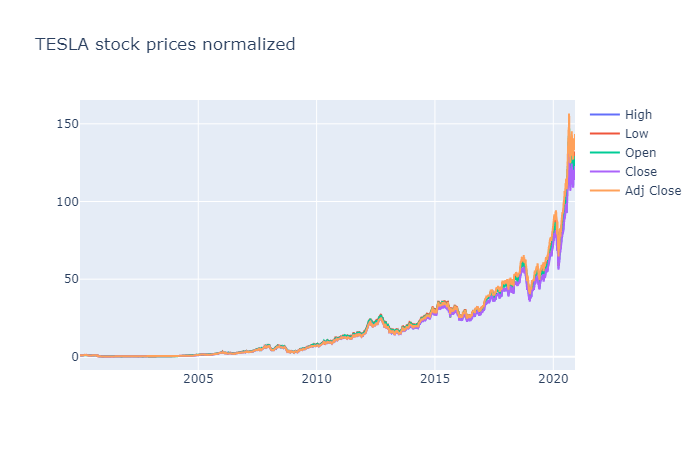

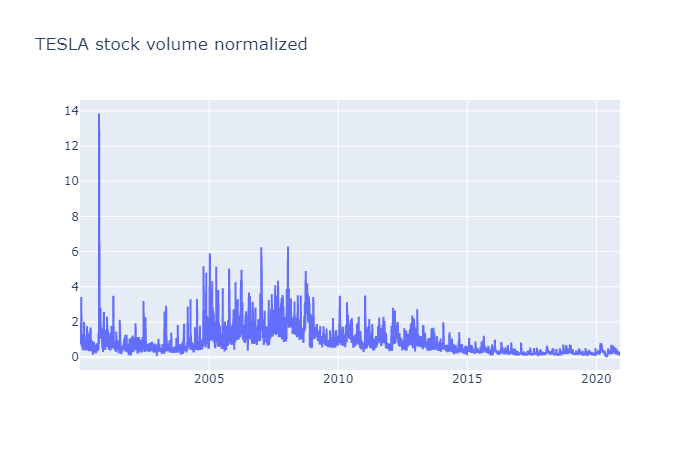

In [12]:
# plot interactive chart for stocks data before normalization
interactive_plot(normalize(Data.drop(columns=['Volume'])), 'TESLA stock prices normalized')
interactive_plot(normalize(Data[['Volume']]), 'TESLA stock volume normalized')

In [13]:
# Function to return the input/output (target) data for AI/ML Model
# Note that our goal is to predict the future stock price 
# Target stock price today will be tomorrow's price 
def training_window(data,look_back):
    df = data.copy()
    for i in range(1,look_back+1):
        df['Close(J-'+str(i)+')'] = df['Close'].shift(i)
    df['Target'] = df[['Close']].shift(-1)
    df = df[look_back:-1]
    return df

In [14]:
look_back = 6
Supervised_data = training_window(Data[['Volume','Close']], look_back)
Supervised_data

,Volume,Close,Close(J-1),Close(J-2),Close(J-3),Close(J-4),Close(J-5),Close(J-6),Target
Date,,,,,,,,,
2000-01-11,4.415488e+08,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442,0.778460
2000-01-12,9.760688e+08,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.863839
2000-01-13,1.032685e+09,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.896763
2000-01-14,3.903760e+08,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928013
2000-01-18,4.591776e+08,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.951451
...,...,...,...,...,...,...,...,...,...
2020-11-23,1.279593e+08,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,119.260002,115.169998
2020-11-24,1.138742e+08,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,116.029999
2020-11-25,7.649920e+07,116.029999,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,116.589996


In [15]:
# Tarin test split
frac_train = 0.7
Split = int(frac_train*Supervised_data.shape[0])
train_df = Supervised_data[:Split]
test_df = Supervised_data[Split:]
display(train_df)
display(test_df)

,Volume,Close,Close(J-1),Close(J-2),Close(J-3),Close(J-4),Close(J-5),Close(J-6),Target
Date,,,,,,,,,
2000-01-11,4.415488e+08,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.999442,0.778460
2000-01-12,9.760688e+08,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.915179,0.863839
2000-01-13,1.032685e+09,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928571,0.896763
2000-01-14,3.903760e+08,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.848214,0.928013
2000-01-18,4.591776e+08,0.928013,0.896763,0.863839,0.778460,0.828125,0.872768,0.888393,0.951451
...,...,...,...,...,...,...,...,...,...
2014-08-20,2.107960e+08,25.142500,25.132500,24.790001,24.495001,24.375000,24.309999,23.992500,25.145000
2014-08-21,1.339120e+08,25.145000,25.142500,25.132500,24.790001,24.495001,24.375000,24.309999,25.330000
2014-08-22,1.767360e+08,25.330000,25.145000,25.142500,25.132500,24.790001,24.495001,24.375000,25.385000


,Volume,Close,Close(J-1),Close(J-2),Close(J-3),Close(J-4),Close(J-5),Close(J-6),Target
Date,,,,,,,,,
2014-08-27,209476000.0,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.132500,25.562500
2014-08-28,273840000.0,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.142500,25.625000
2014-08-29,178380000.0,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,25.145000,25.825001
2014-09-02,214256000.0,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,25.330000,24.735001
2014-09-03,501684000.0,24.735001,25.825001,25.625000,25.562500,25.532499,25.222500,25.385000,24.530001
...,...,...,...,...,...,...,...,...,...
2020-11-23,127959300.0,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,119.260002,115.169998
2020-11-24,113874200.0,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,120.300003,116.029999
2020-11-25,76499200.0,116.029999,115.169998,113.849998,117.339996,118.639999,118.029999,119.389999,116.589996


In [16]:
# Scale the data and divide it into variable X and traget y
# Note that we will devide data into train and test before scaling to avoid data linkage
sc = MinMaxScaler(feature_range=(0,1))
train = sc.fit_transform(train_df)
test = sc.fit_transform(test_df)
X_train = train[:,:-1]
y_train = train[:,-1:]
X_test = test[:,:-1]
y_test = test[:,-1:]
print('X train shape is {} and y train shape is {}'.format(X_train.shape,y_train.shape))
print('X test shape is {} and y test shape is {}'.format(X_test.shape,y_test.shape))

X train shape is (3679, 8) and y train shape is (3679, 1)
X test shape is (1577, 8) and y test shape is (1577, 1)


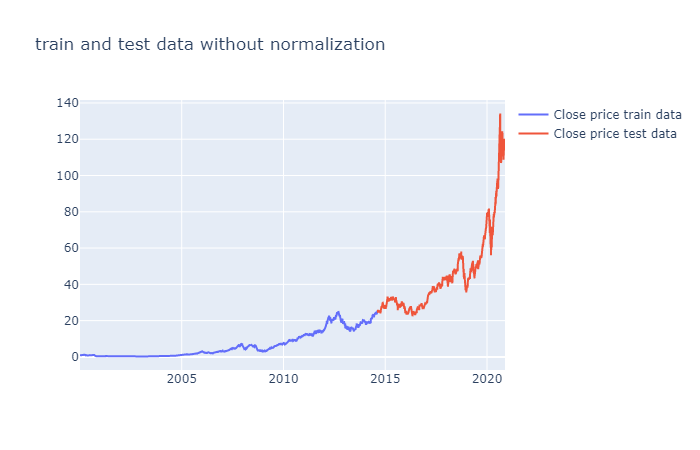

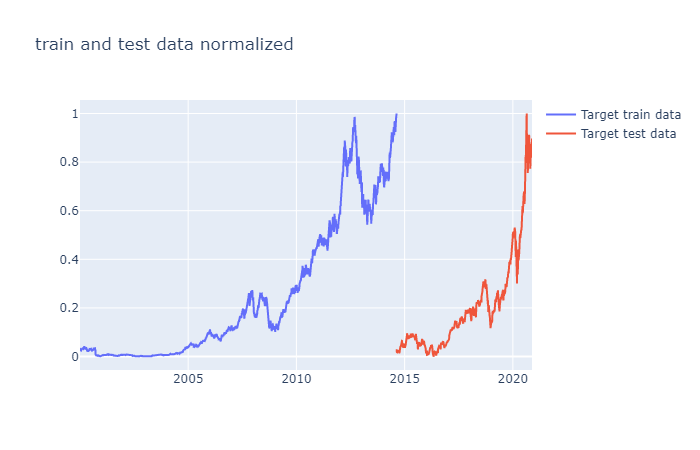

In [18]:
# Plot train data and test data without normalization 
fig = px.line(title = 'train and test data without normalization')
fig.add_scatter(x = Data.index[:Split], y = train_df['Close'],mode='lines', name = 'Close price train data')
fig.add_scatter(x = Data.index[Split:], y = test_df['Close'],mode='lines', name = 'Close price test data')
fig.show("png")
# Plot train data and test data normalized 
fig = px.line(title = 'train and test data normalized')
fig.add_scatter(x = Data.index[:Split], y = y_train[:,0],mode='lines', name = 'Target train data')
fig.add_scatter(x = Data.index[Split:], y = y_test[:,0],mode='lines', name = 'Target test data')
fig.show("png")

In [19]:
# Reshape the 1D arrays to 3D arrays to feed in the model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_train.shape, X_test.shape

((3679, 8, 1), (1577, 8, 1))

In [29]:
from keras.regularizers import l2
# Create the model
inputs = keras.layers.Input(shape = (X_train.shape[1], X_train.shape[2]))
x = keras.layers.LSTM(150, return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.001))(inputs)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150, return_sequences=True, recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.001))(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.LSTM(150)(x)
outputs = keras.layers.Dense(1, activation = 'linear')(x)

model = keras.Model(inputs=inputs, outputs= outputs)
model.compile(optimizer = 'adam', loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 1)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8, 150)            91200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 150)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 8, 150)            180600    
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 150)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150)               180600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 151 

In [30]:
# Train the model and save validation loss split in train
n_epochs = 100
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_split=0.2)

Train on 2943 samples, validate on 736 samples
Epoch 1/100
2943/2943 [==============================] - 6s 2ms/sample - loss: 1.0626 - val_loss: 0.3153
Epoch 2/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.2435 - val_loss: 0.2056
Epoch 3/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.1844 - val_loss: 0.1655
Epoch 4/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.1483 - val_loss: 0.1335
Epoch 5/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.1183 - val_loss: 0.1056
Epoch 6/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.0932 - val_loss: 0.0870
Epoch 7/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.0725 - val_loss: 0.0641
Epoch 8/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.0556 - val_loss: 0.0486
Epoch 9/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 0.0420 - val_loss: 0.0366
Epoch 10

2943/2943 [==============================] - 4s 1ms/sample - loss: 1.0196e-04 - val_loss: 0.0090
Epoch 76/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 9.8836e-05 - val_loss: 0.0081
Epoch 77/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 1.0361e-04 - val_loss: 0.0136
Epoch 78/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 1.1520e-04 - val_loss: 0.0082
Epoch 79/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 8.7372e-05 - val_loss: 0.0103
Epoch 80/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 8.4828e-05 - val_loss: 0.0129
Epoch 81/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 9.0285e-05 - val_loss: 0.0160
Epoch 82/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 8.9090e-05 - val_loss: 0.0098
Epoch 83/100
2943/2943 [==============================] - 4s 1ms/sample - loss: 1.1263e-04 - val_loss: 0.0212
Epoch 84/100
2943/2943 

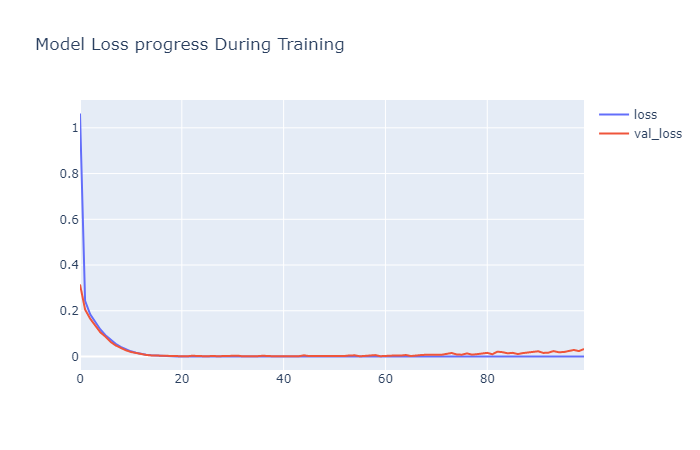

In [31]:
# Plot Model Loss progress During Training'
interactive_plot(pd.DataFrame(history.history), 'Model Loss progress During Training')

In [32]:
# from the loss plot we can see that the validation loss is less volatile between 60 and 80
# we'll choose 70 epochs for training
# Train the model with validation_data
n_epochs = 40
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model.fit(X_train, y_train, epochs=n_epochs, batch_size=32, validation_data=(X_test,y_test))

Train on 3679 samples, validate on 1577 samples
Epoch 1/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 7.0901e-04 - val_loss: 9.0530e-04
Epoch 2/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 4.1624e-04 - val_loss: 3.0759e-04
Epoch 3/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 3.7989e-04 - val_loss: 4.0321e-04
Epoch 4/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 4.8507e-04 - val_loss: 3.1337e-04
Epoch 5/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 3.3214e-04 - val_loss: 2.8552e-04
Epoch 6/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 2.9077e-04 - val_loss: 2.9804e-04
Epoch 7/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 3.6131e-04 - val_loss: 3.0936e-04
Epoch 8/40
3679/3679 [==============================] - 5s 1ms/sample - loss: 3.3342e-04 - val_loss: 3.8420e-04
Epoch 9/40
3679/3679 [==============================] - 

In [33]:
# Inverse scale predictions and add predictions to supervised data 
#test_df = test_df.drop(columns=['Target'])
predictions = model.predict(X_test)
Predictions_df = pd.DataFrame(X_test[:,:,0], columns = test_df.columns[:-1], index=test_df.index)
Predictions_df['Predictions'] = predictions
Predictions_df = pd.DataFrame(sc.inverse_transform(Predictions_df),columns=Predictions_df.columns, index=Predictions_df.index)
Predictions_df['Target'] = test_df['Target']
Predictions_df = Predictions_df[['Target','Predictions']]
Predictions_df

,Target,Predictions
Date,,
2014-08-27,25.562500,25.314317
2014-08-28,25.625000,25.401716
2014-08-29,25.825001,25.446056
2014-09-02,24.735001,25.545922
2014-09-03,24.530001,25.742900
...,...,...
2020-11-23,115.169998,113.319062
2020-11-24,116.029999,112.310403
2020-11-25,116.589996,111.733877


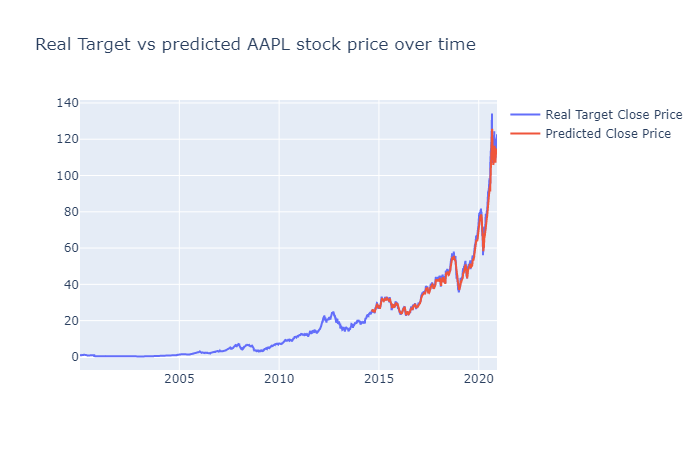

In [34]:
# Plot predictions over time
fig = px.line(title = 'Real Target vs predicted '+ stock + ' stock price over time')
fig.add_scatter(x = Supervised_data.index, y = Supervised_data['Target'],mode='lines', name = 'Real Target Close Price')
fig.add_scatter(x = Predictions_df.index, y = Predictions_df['Predictions'],mode='lines', name = 'Predicted Close Price')
fig.show("png")

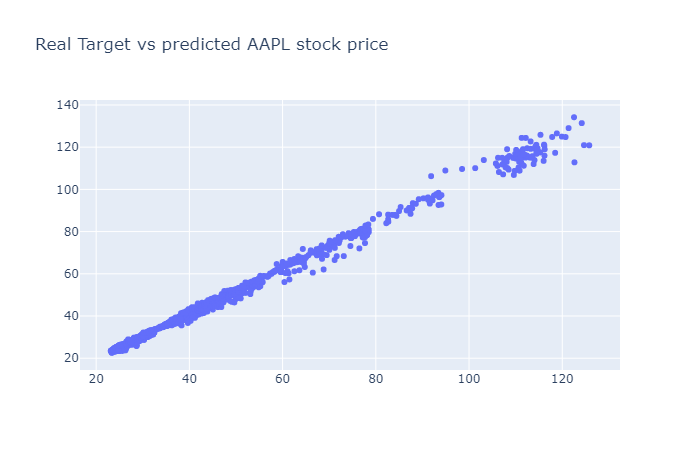

In [35]:
# Plot predictions vs target
fig = px.scatter(title = 'Real Target vs predicted '+ stock + ' stock price')
fig.add_trace(go.Scatter(x = Predictions_df['Predictions'], y = Predictions_df['Target'],mode = 'markers'))
fig.show("png")

In [36]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
R2_score = r2_score(Predictions_df['Predictions'],Predictions_df['Target'])
MSE = mean_squared_error(Predictions_df['Predictions'],Predictions_df['Target'])
RMSE = MSE**(1/2)
MAE = mean_absolute_error(Predictions_df['Predictions'],Predictions_df['Target'])
print('R2_score is {}'.format(R2_score))
print('-'*50)
print('The mean squared error is {}'.format(MSE))
print('-'*50)
print('The root mean squared error is {}'.format(RMSE))
print('-'*50)
print('the mean absolute error is {}'.format(MAE))
print('-'*50)

R2_score is 0.9902575956003052
--------------------------------------------------
The mean squared error is 4.737071556862545
--------------------------------------------------
The root mean squared error is 2.176481462558904
--------------------------------------------------
the mean absolute error is 1.4266703038611042
--------------------------------------------------
